In [4]:
import numpy as np 
import nibabel as nib 
import matplotlib.pyplot as plt 
import nilearn.plotting as niplt
%matplotlib inline
import os 

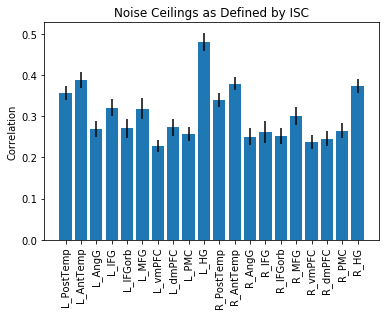

In [5]:
#View ISC Results
results=[]
black_subs=['sub-300', 'sub-304', 'sub-293', 'sub-273', 'sub-265', 'sub-307', 'sub-283', 'sub-275', 
'sub-291', 'sub-297', 'sub-303', 'sub-294', 'sub-286', 'sub-282', 'sub-310', 'sub-302', 'sub-312', 
'sub-301', 'sub-287', 'sub-298', 'sub-313', 'sub-285', 'sub-292', 'sub-311', 'sub-267', 'sub-295', 
'sub-305', 'sub-274', 'sub-290', 'sub-288', 'sub-281', 'sub-276', 'sub-277', 'sub-299', 'sub-308',
 'sub-272', 'sub-284', 'sub-289', 'sub-280', 'sub-309', 'sub-306', 'sub-296', 'sub-127', 'sub-279', 
 'sub-315', 'sub-314']
slumlordreach_subs=['sub-145', 'sub-143', 'sub-016', 'sub-142', 'sub-141', 'sub-133', 'sub-140', 'sub-136', 
'sub-084', 'sub-135', 'sub-137', 'sub-138', 'sub-111', 'sub-106', 'sub-134', 'sub-132', 'sub-144']

rois=['PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC','HG']
roi_names=['L_'+roi for roi in rois]+['R_'+roi for roi in rois] 
def bootstrap_errors(data):
    mean=data.mean()
    sampling=[]
    for _ in range(10000):
        sampling.append(np.mean(np.random.choice(data,size=len(data),replace=True)))
    sampling=np.asarray(sampling)
    ci=np.percentile(sampling,[2.5,97.5])
    return np.abs(ci-mean)
    #err=1.960*(np.std(sampling,ddof=1)/len(data))
    #return [err,err]

def barplot(dataset,rep_names,normalize_isc=False):
    barWidth=0.8/len(rep_names)
    for r_idx,rep_name in enumerate(rep_names):
        results=get_result_dataset(dataset,rep_name,normalize_isc=normalize_isc)
        errors=np.asarray([bootstrap_errors(results[:,i]) for i in range(results.shape[1])])
        print(results.max())
        plt.bar([i+(r_idx*barWidth) for i in range(20)],results.mean(axis=0),yerr=errors.T,width=barWidth)
    if 'layer' not in rep_names[0]:
        plt.legend([r[18:] for r in rep_names])
    else:
        plt.legend(rep_names)
    plt.xticks(list(range(20)),roi_names,rotation=90)
    if len(dataset)==2:
        story_name='Combined Storys'
    else:
        story_name=dataset[0]
    plt.title(story_name)
    plt.ylabel("Pearson's R")
dataset=['black','slumlordreach']
for story in dataset:
    results_story=[]
    if story=='black':
        subs=black_subs
    if story=='slumlordreach':
        subs=slumlordreach_subs
    roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI.npy')
    for sub in subs:
        results_sub_parcels=np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy')
        results_sub=np.zeros((20,))
        for roi in range(20):
            results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean() 
        results_story.append(results_sub)
    results_story=np.asarray(results_story)
    results.append(results_story)
results=np.asarray(results)
isc_results=np.concatenate(results,axis=0)
errors=np.asarray([bootstrap_errors(isc_results[:,i]) for i in range(isc_results.shape[1])])
plt.bar(list(range(20)),isc_results.mean(axis=0),yerr=errors.T)
plt.xticks(list(range(20)),roi_names,rotation=90)
plt.ylabel("Correlation")
plt.title("Noise Ceilings as Defined by ISC")

noise_ceiling=isc_results.mean(axis=0)


In [25]:
isc_results.shape

(63, 20)

In [27]:




def permutation_t_test(data1,data2): 
    diff=data1-data2
    stderr=np.std(diff,ddof=1)/np.sqrt(len(diff))+1e-9
    original_t=np.mean(diff)/stderr
    permutations=[]
    flip_diff=diff.copy()
    for _ in range(10000):
        flip_idxs=np.random.choice([0,1],size=len(diff),replace=True).astype('bool')
        flip_diff[flip_idxs]=diff[flip_idxs]*-1
        flip_diff[~flip_idxs]=diff[~flip_idxs]  
        flip_stderr=np.std(flip_diff,ddof=1)/np.sqrt(len(flip_diff))+1e-9 
        permutations.append(np.mean(flip_diff)/flip_stderr)
    permutations=np.asarray(permutations)

    if original_t<0:
        p_value=float(np.sum(permutations<=original_t))/len(permutations)
    else:
        p_value=float(np.sum(permutations>=original_t))/len(permutations)
    return original_t,p_value



def get_result_dataset(dataset,rep_name,normalize_isc=True):
    results=[]
    noise_ceilings=[]
    for story in dataset:
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        for sub in subs:
            noise_ceilings.append(np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy'))
    noise_ceilings=np.asarray(noise_ceilings)
    noise_ceilings=np.mean(noise_ceilings,axis=0)
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        if 'layer' not in rep_name and 'ling' not in rep_name:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+story+"_"+rep_name+"/"
        else:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+rep_name+"/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI.npy')
        for sub in subs:
            results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            if normalize_isc:
                results_sub_parcels=(results_sub_parcels/noise_ceilings)*100.0
            results_sub=np.zeros((20,))
            for roi in range(20):
                results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean() 
            results_story.append(results_sub)
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    return np.concatenate(results,axis=0)
    #if normalize_isc:
    #    return (np.concatenate(results,axis=0)/noise_ceiling)*100.0
    #else:
    #    return np.concatenate(results,axis=0)
            



def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig] 

def comparison_barplot(dataset,rep_names):
    barWidth=0.8 
    results1=get_result_dataset(dataset,rep_names[0])
    results2=get_result_dataset(dataset,rep_names[1])
    perm_results=np.asarray([permutation_t_test(results1[:,i],results2[:,i]) for i in range(20)])
    t_values=perm_results[:,0]
    
    p_values=p_adjust_bh(perm_results[:,1])
    t_values[p_values>0.05]=0.0
    #print(p_values)
    results=t_values.copy()
    #errors=np.asarray([bootstrap_errors(results[:,i]) for i in range(results.shape[1])])
    plt.bar([i for i in range(20)],results,width=barWidth)
    if len(dataset)==2:
        story_name='Combined Storys'
    else:
        story_name=dataset[0]
    plt.xticks(list(range(20)),roi_names,rotation=90)
    plt.title(rep_names[0]+" vs "+rep_names[1]+" / "+story_name)
    #plt.ylabel("Pearson's R")



In [7]:
fnames=os.listdir('/jukebox/griffiths/bert-brains/code/bert-brains/data/black/bert-base-uncased/syntactic_analyses/')
dataset=['black','slumlordreach']
reps=[rep[6:-4] for rep in fnames]
reps 

['bert-base-uncased_semantic_composition_20-TRs',
 'bert-base-uncased_semantic_composition_0-TRs',
 'bert-base-uncased_syntactic_complexity_L-inf_T-20_D-concat',
 'bert-base-uncased_semantic_composition_1-TRs',
 'bert-base-uncased_syntactic_complexity_L-1_T-128_D-concat',
 'bert-base-uncased_syntactic_distance_T-128_D-bck',
 'bert-base-uncased_syntactic_complexity_L-inf_T-10_D-bck',
 'bert-base-uncased_syntactic_complexity_L-inf_T-10_D-concat',
 'bert-base-uncased_semantic_composition_5-TRs',
 'bert-base-uncased_syntactic_complexity_L-1_T-20_D-fwd',
 'bert-base-uncased_syntactic_distance_T-10_D-fwd',
 'bert-base-uncased_syntactic_complexity_L-inf_T-20_D-bck',
 'bert-base-uncased_syntactic_complexity_L-1_T-128_D-fwd',
 'bert-base-uncased_syntactic_complexity_L-1_T-10_D-concat',
 'bert-base-uncased_semantic_composition_2-TRs',
 'bert-base-uncased_semantic_composition_10-TRs',
 'bert-base-uncased_syntactic_distance_T-128_D-concat',
 'bert-base-uncased_syntactic_complexity_L-1_T-10_D-fwd',

93.18499738099729
107.92672113941885


Text(0, 0.5, 'Percent of Noise Ceiling')

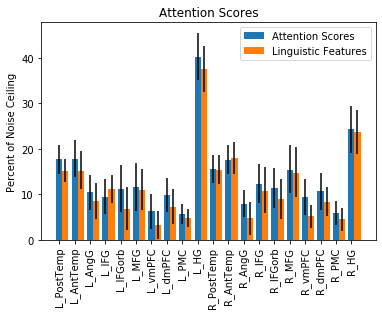

In [11]:

#results=get_result_dataset(['slumlordreach','black'],'bert-base-uncased_syntactic_complexity_L-inf_T-128_D-concat')
#print(results)
barplot(['slumlordreach','black'],['bert-base-uncased_syntactic_complexity_L-inf_T-128_D-concat','ling_features'],normalize_isc=True)
plt.title("Attention Scores")
plt.legend(['Attention Scores','Linguistic Features'])
plt.ylabel("Percent of Noise Ceiling")

[0.214      0.27288889 0.29046154 0.31414286 0.214      0.42410526
 0.214      0.24142857 0.29046154 0.214      0.4463     0.42410526
 0.214      0.3464     0.29046154 0.42410526 0.116      0.27288889
 0.29046154 0.42410526]


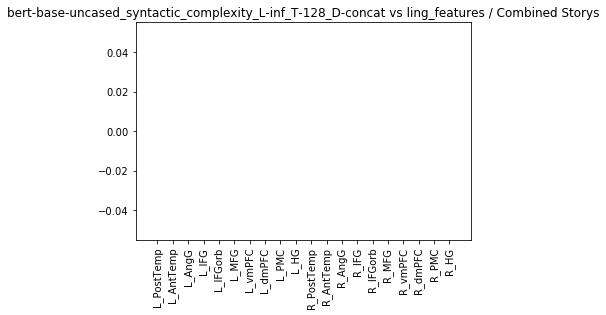

In [22]:
comparison_barplot(['slumlordreach','black'],['bert-base-uncased_syntactic_complexity_L-inf_T-128_D-concat','ling_features'])
plt.ylabel("Difference in Percent of Noise Ceiling")
plt.ylim(-8,8)
plt.title("Attention Scores Minus Linguistic Features")


68.61147528271472
98.78224734835108
107.92672113941886
63.780357697832926
84.06714285602237
107.92672113941886
69.1097337280547
71.50451646032981
107.92672113941886
75.87850612838723
73.88175041662527
107.92672113941886
78.34926217490359
73.66752188766537
107.92672113941886
81.77219800269039
84.14794148808883
107.92672113941886
98.8451260787496
98.03196362420323
107.92672113941886
102.29203425613927
95.46898494304665
107.92672113941886
102.85689146595139
104.28172032187294
107.92672113941886
103.43779942459453
102.75234740158955
107.92672113941886
101.34303914526926
93.4811281029975
107.92672113941886
96.92861811136392
77.79691993159409
107.92672113941886


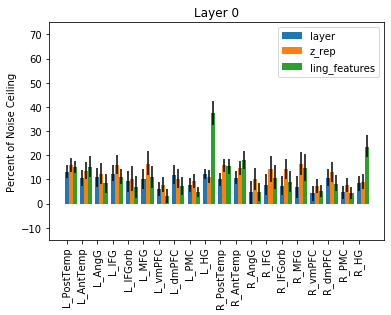

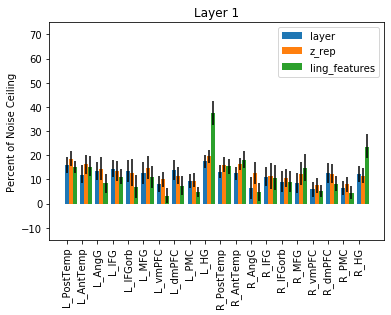

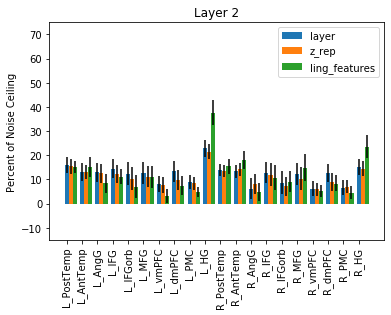

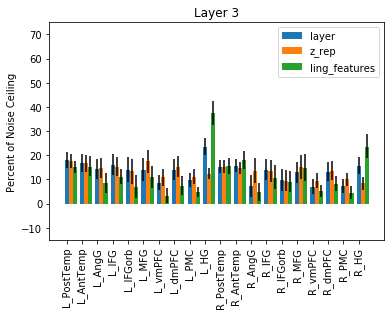

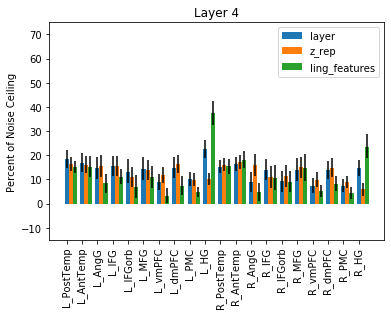

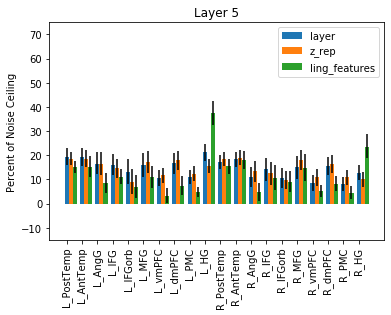

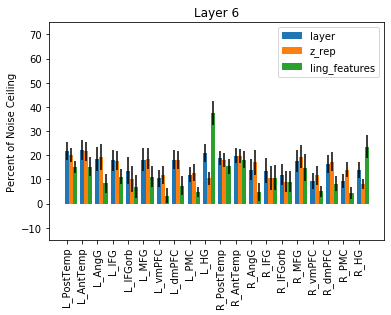

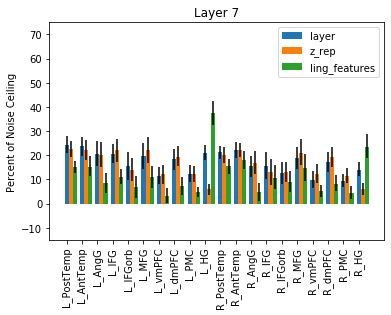

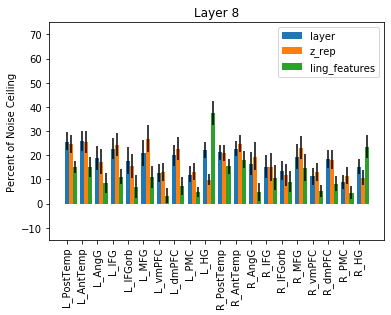

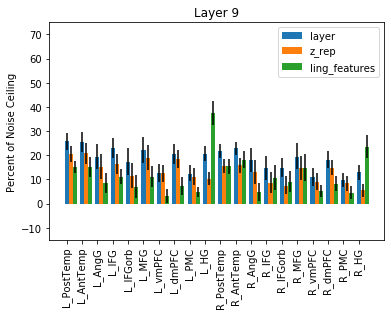

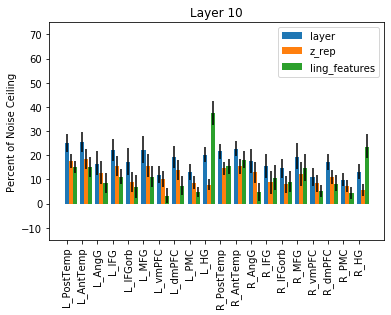

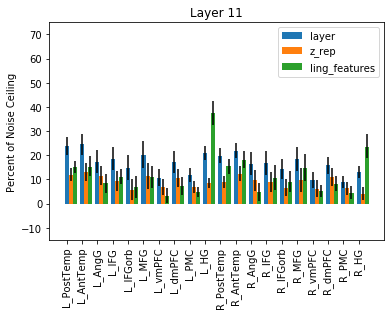

In [12]:
dataset=['black','slumlordreach']
for i in range(12):
    plt.figure() 
    barplot(dataset,['layer_'+str(i+1)+"_activations",'layer_'+str(i)+"_z_representations",'ling_features'],normalize_isc=True)
    plt.title("Layer "+str(i))
    plt.legend(['layer','z_rep','ling_features'])
    plt.ylabel("Percent of Noise Ceiling")
    plt.ylim(-15,75.0)

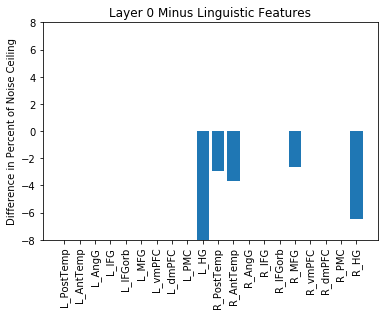

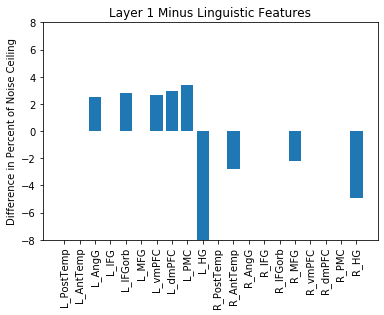

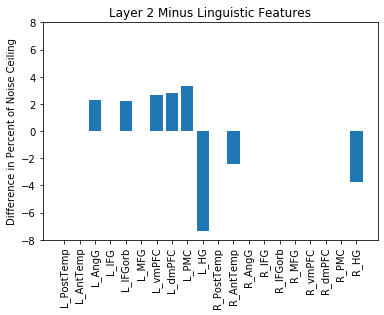

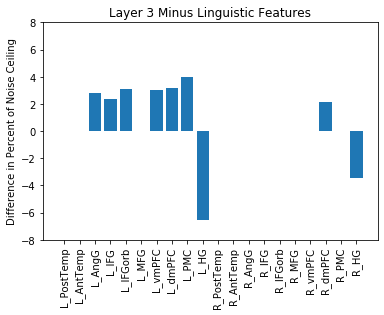

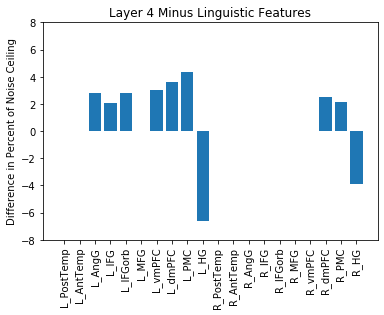

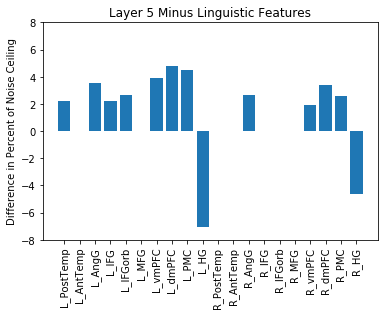

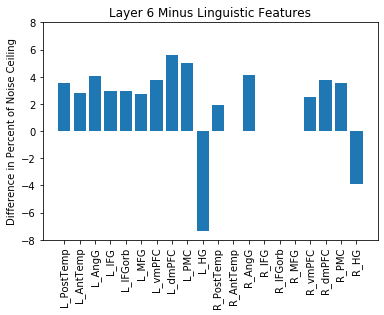

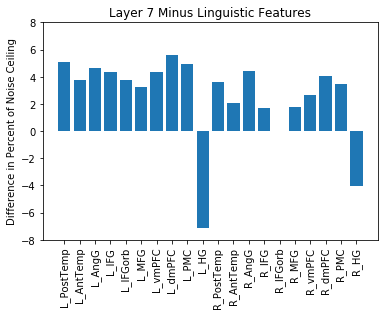

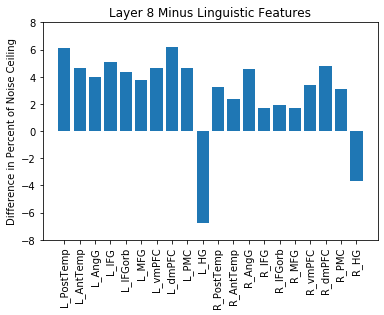

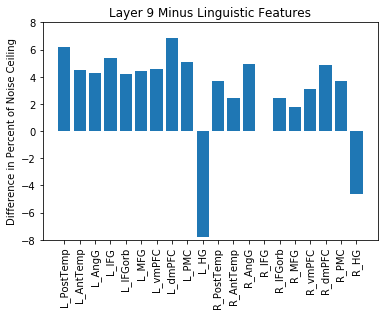

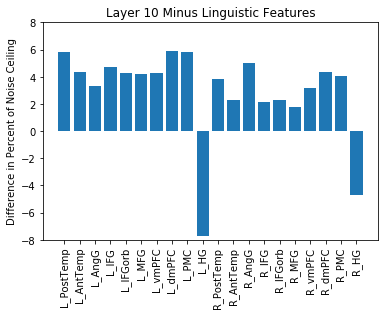

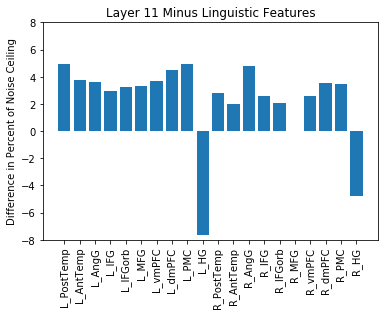

In [30]:
for i in range(12):
    plt.figure() 
    comparison_barplot(dataset,['layer_'+str(i+1)+"_activations",'ling_features'])
    plt.title("Layer "+str(i)+" Minus Linguistic Features")

    plt.ylabel("Difference in Percent of Noise Ceiling")
    plt.ylim(-8,8)

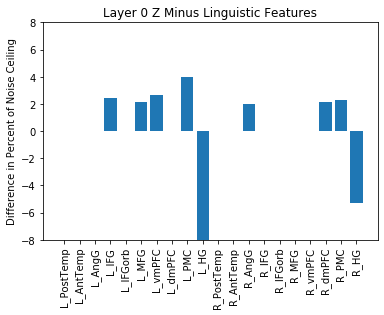

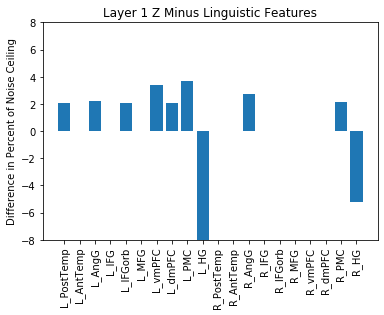

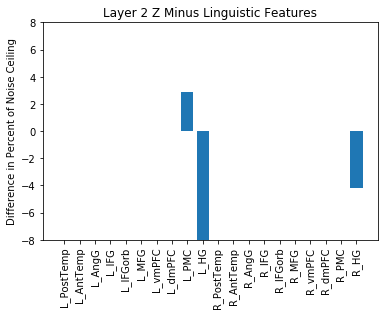

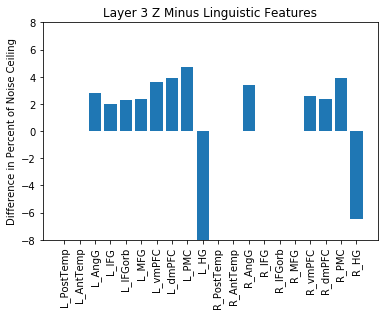

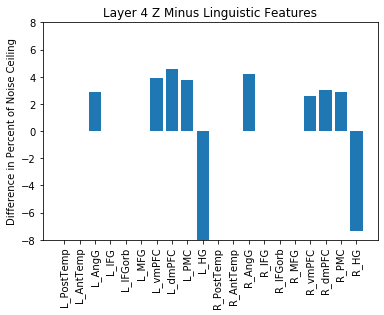

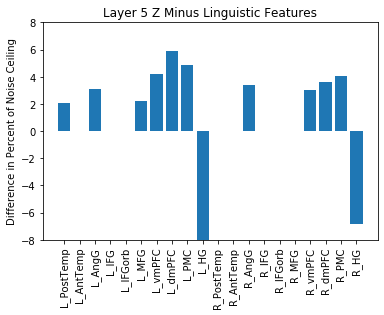

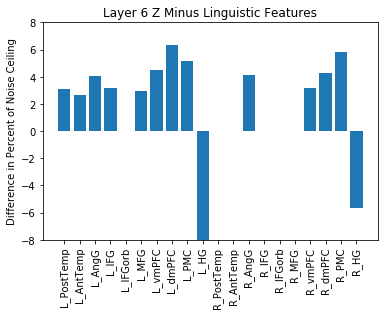

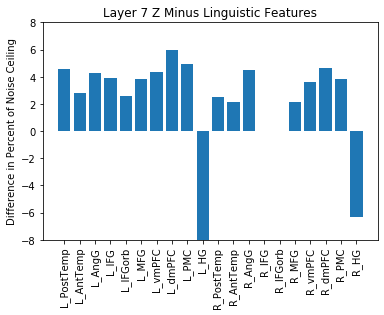

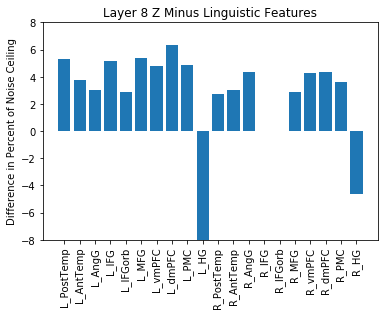

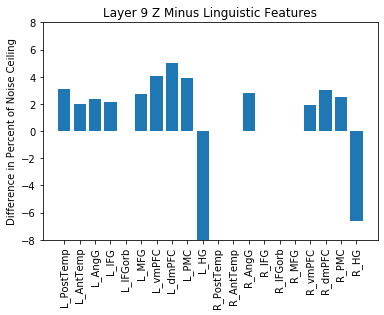

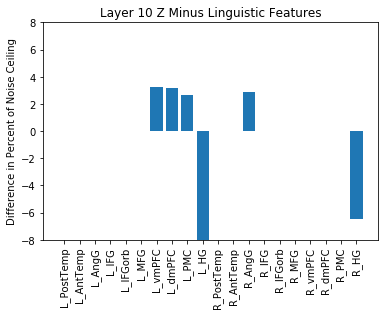

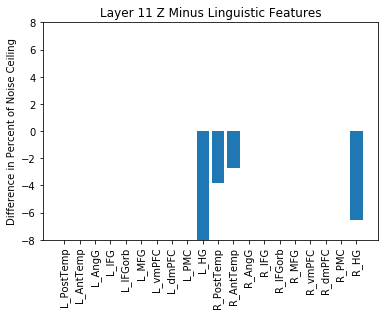

In [32]:

for i in range(12):
    plt.figure() 
    comparison_barplot(dataset,['layer_'+str(i)+"_z_representations",'ling_features'])
    plt.title("Layer "+str(i)+" Z Minus Linguistic Features")
    plt.ylabel("Difference in Percent of Noise Ceiling")
    plt.ylim(-8,8)